In [54]:
# Install prerequisites

# pip install kaggle

# New Section

In [55]:
# Import required packages

import json
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [56]:
# Connect to Kaggle

if "kaggle.json" in os.listdir():
  with open("kaggle.json") as f:
    line = f.readline()
    kaggle_auth = json.loads(line)
    f.close()
else:
  kaggle_auth = {"username":"dattaat","key":"6186267d81bdee051287be2596e561c7"}

os.environ["KAGGLE_USERNAME"] = kaggle_auth["username"]
os.environ["KAGGLE_KEY"] = kaggle_auth["key"]

kaggle_auth

{'username': 'dattaat', 'key': '6186267d81bdee051287be2596e561c7'}

In [57]:
# Get Kaggle datasets

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
dataset_names = [
    "osmi/mental-health-in-tech-2016",
    "osmihelp/osmi-mental-health-in-tech-survey-2017",
    "osmihelp/osmi-mental-health-in-tech-survey-2018",
    "osmihelp/osmi-mental-health-in-tech-survey-2019",
]
for dataset_name in dataset_names:
  api.dataset_download_files(dataset_name, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/osmi/mental-health-in-tech-2016
Dataset URL: https://www.kaggle.com/datasets/osmihelp/osmi-mental-health-in-tech-survey-2017
Dataset URL: https://www.kaggle.com/datasets/osmihelp/osmi-mental-health-in-tech-survey-2018
Dataset URL: https://www.kaggle.com/datasets/osmihelp/osmi-mental-health-in-tech-survey-2019


In [58]:
# Upload csvs, organize by year

csv_names = [file for file in os.listdir() if ".csv" in file and file != "data.csv"]
def extract_year(filename):
    pattern = r'\d{4}'
    match = re.search(pattern, filename)
    if match:
        return int(match.group())
    else:
        return 0  # Return 0 if no year is found
csv_names = sorted(csv_names, key=extract_year)
csv_names

['mental-heath-in-tech-2016_20161114.csv',
 'OSMI Mental Health in Tech Survey 2017.csv',
 'OSMI Mental Health in Tech Survey 2018.csv',
 'OSMI 2019 Mental Health in Tech Survey Results - OSMI Mental Health in Tech Survey 2019.csv']

In [59]:
# Turn CSVs into dataframe, mark the year, merge

dfs = []
for csv_name in csv_names:
  filepath = os.path.join(os.getcwd(), csv_name)
  df = pd.read_csv(filepath)

  # Clean dataframe

  if "2016" in csv_name:
    year = 2016
  elif "2017" in csv_name:
    year = 2017
  elif "2018" in csv_name:
    year = 2018
  elif "2019" in csv_name:
    year = 2019
  df["Year"] = [year] * len(df)

  column_name1 = "How many employees does your company or organization have?"

  column_name2 = "What is your age?"
  for i in range(len(df[column_name2].values)):
    value = df[column_name2].values[i]
    try:
      value = int(float(value))
    except:
      value = 0
    if value > 130: # People aren't older than 130
      value = 0
    elif value < 0: # People aren't younger than 0
      value = 0
    df[column_name2].iloc[i] = value

  column_name3 = "What is your gender?"
  for i in range(len(df[column_name3].values)):
    value = df[column_name3].values[i]
    value = str(value).lower().strip()
    if value == "m":
      value = "male"
    elif value == "f":
      value = "female"
    elif value == "dude":
      value = "male"
    elif "female" in value:
      value = "female"
    elif "femail" in value:
      value = "female"
    elif "male" in value:
      value = "male"
    elif "mail" in value:
      value = "male"
    elif "woman" in value:
      value = "female"
    elif "man" in value:
      value = "male"
    elif "boy" in value:
      value = "male"
    elif "girl" in value:
      value = "female"
    else:
      value = "other"
    df[column_name3].iloc[i] = value

  column_name4 = "Do you currently have a mental health disorder?"
  column_name4b = "Do you *currently* have a mental health disorder?"
  if column_name4b in df.columns:
    df = df.rename(columns={column_name4b: column_name4})
  for i in range(len(df[column_name4].values)):
    value = df[column_name4].values[i]
    value = str(value).lower().strip()
    if value in ["maybe", "possibly", "don't know"]:
      value = "not sure"
    df[column_name4].iloc[i] = value

  column_name5 = "What country do you live in?"
  column_name5b = "What country do you <strong>live</strong> in?"
  column_name5c = "What country do you *live* in?"
  if column_name5b in df.columns:
    df = df.rename(columns={column_name4b: column_name5})
  if column_name5c in df.columns:
    df = df.rename(columns={column_name5c: column_name5})

  column_names = [column_name1, column_name2, column_name3, column_name4, column_name5, "Year"]
  data = df.to_dict("records")
  df = pd.DataFrame(data=data, columns=column_names)

  dfs.append(df)

# Merge

df = pd.concat(dfs, ignore_index=True)

# Save as CSV

df.to_csv("data.csv")

# Display

df

,How many employees does your company or organization have?,What is your age?,What is your gender?,Do you currently have a mental health disorder?,What country do you live in?,Year
0,26-100,39.0,male,no,United Kingdom,2016
1,6-25,29.0,male,yes,United States of America,2016
2,6-25,38.0,male,no,United Kingdom,2016
3,NaN,43.0,male,yes,United Kingdom,2016
4,6-25,43.0,female,yes,United States of America,2016
...,...,...,...,...,...,...
2953,More than 1000,27.0,male,not sure,India,2019
2954,NaN,48.0,male,no,United States of America,2019
2955,NaN,50.0,male,no,India,2019
2956,More than 1000,30.0,female,not sure,India,2019


In [60]:
df["How many employees does your company or organization have?"].value_counts()

How many employees does your company or organization have?
More than 1000    630
100-500           612
26-100            535
6-25              399
500-1000          186
1-5                92
Name: count, dtype: int64

In [61]:
df["What is your gender?"].value_counts()

What is your gender?
male      2058
female     791
other      109
Name: count, dtype: int64

In [62]:
df["What country do you live in?"].value_counts()

What country do you live in?
United States of America    1044
United Kingdom               212
Canada                        93
Germany                       62
Netherlands                   52
Australia                     35
Brazil                        27
India                         22
Sweden                        19
Portugal                      18
France                        17
Ireland                       17
Switzerland                   14
New Zealand                   11
Russia                         9
Norway                         8
Poland                         7
Bulgaria                       7
Italy                          7
Denmark                        7
Belgium                        7
Spain                          7
Finland                        7
South Africa                   6
Pakistan                       5
Austria                        5
Mexico                         4
Estonia                        4
Romania                        4
Czech Republic

In [63]:
df["Year"].value_counts()

Year
2016    1433
2017     756
2018     417
2019     352
Name: count, dtype: int64

In [64]:
df["Do you currently have a mental health disorder?"].value_counts()

Do you currently have a mental health disorder?
yes         1237
no           969
not sure     752
Name: count, dtype: int64

Charts

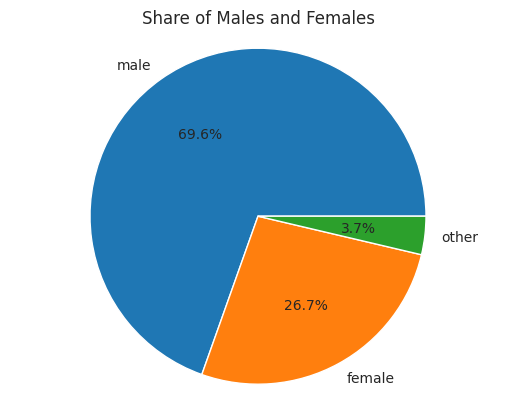

In [65]:
# Overall male vs. female

import matplotlib.pyplot as plt
gender_counts = df["What is your gender?"].value_counts()
labels = gender_counts.index
values = gender_counts.values
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Share of Males and Females")
plt.show()

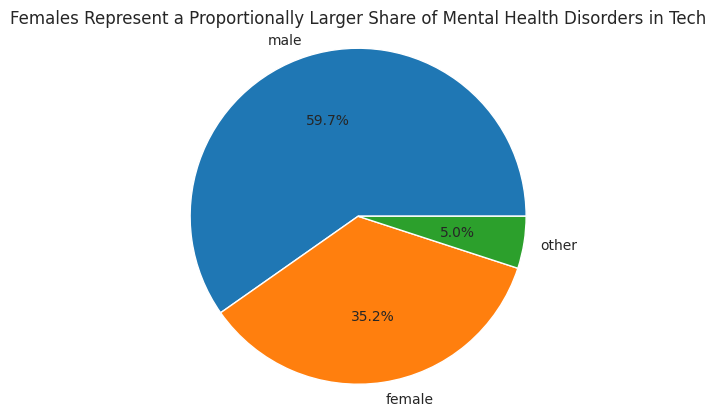

In [66]:
# Male vs. female for mental health disorder

import matplotlib.pyplot as plt
filtered_df = df[df["Do you currently have a mental health disorder?"] == "yes"]
gender_counts = filtered_df["What is your gender?"].value_counts()
labels = gender_counts.index
values = gender_counts.values
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Females Represent a Proportionally Larger Share of Mental Health Disorders in Tech")
plt.show()

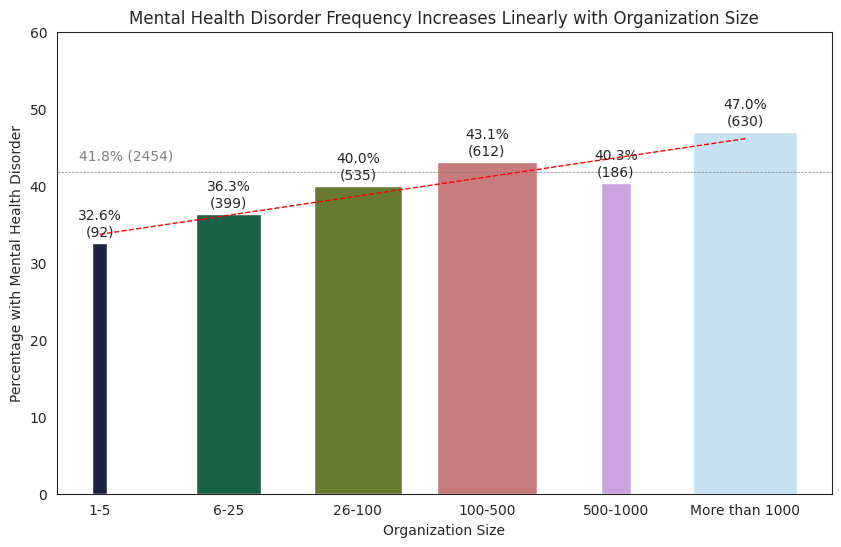

In [82]:
# Mental health by org size

import matplotlib.pyplot as plt

# Get and sort the different org sizes
org_sizes = df["How many employees does your company or organization have?"].unique()
org_sizes = [item for item in org_sizes if isinstance(item, str)]
def convert_size(size):
    if size == 'More than 1000':
        return (float('inf'), size)
    else:
        lower, upper = map(int, size.split('-'))
        return (lower, upper, size)
org_sizes = sorted(org_sizes, key=convert_size)

# Calculate the count and percentage for each organization size
percentages, total_counts = [], []
for size in org_sizes:
    size_data = df[df["How many employees does your company or organization have?"] == size]
    total_count = len(size_data)
    total_counts.append(total_count)
    disorder_count = len(size_data[size_data["Do you currently have a mental health disorder?"] == "yes"])
    try:
      percentage = (disorder_count / total_count) * 100
    except ZeroDivisionError:
      percentage = 0
    percentages.append(percentage)

# Create the bar chart, color it, and make widths reflect sample size
plt.figure(figsize=(10, 6))
sns.set_style("white")
bar_colors = sns.color_palette(palette="cubehelix", n_colors=len(org_sizes))
bar_width = 0.8
bar_widths = [bar_width * count / max(total_counts) for count in total_counts]
bars = plt.bar(x=org_sizes, height=percentages, width=bar_widths, color=bar_colors)

# Plot overall average as red dash line
total_disorder = len(df[df["Do you currently have a mental health disorder?"] == "yes"])
pct_disorder = total_disorder / len(df) * 100
plt.axhline(y=pct_disorder, color='grey', linestyle='--', linewidth=0.5)
x_min, x_max = plt.xlim()
x_pos = x_max - (x_max - x_min) * 0.85
y_pos = pct_disorder * 1.05
line_text = f"{round(pct_disorder,1)}% ({sum(total_counts)})"
plt.text(x=x_pos, y=y_pos, s=line_text, color='grey', ha='right', va='center')

# Add a trendline
org_size_positions = np.arange(len(org_sizes))
slope, intercept = np.polyfit(org_size_positions, percentages, 1)
trendline_x = np.linspace(min(org_size_positions), max(org_size_positions), 100)
trendline_y = slope * trendline_x + intercept
plt.plot(trendline_x, trendline_y, color='red', linestyle='--', linewidth=1)

# Add data labels to top of bars
for i in range(len(bars)):
    bar = bars[i]
    height = bar.get_height()
    plt.annotate(
        text=f"{round(height,1)}%\n({total_counts[i]})",
        xy = (bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom'
    )

# Add titles and style
plt.yticks(range(0, 61, 10))
plt.xlabel("Organization Size")
plt.ylabel("Percentage with Mental Health Disorder")
plt.title("Mental Health Disorder Frequency Increases Linearly with Organization Size")


# Show it
plt.show()

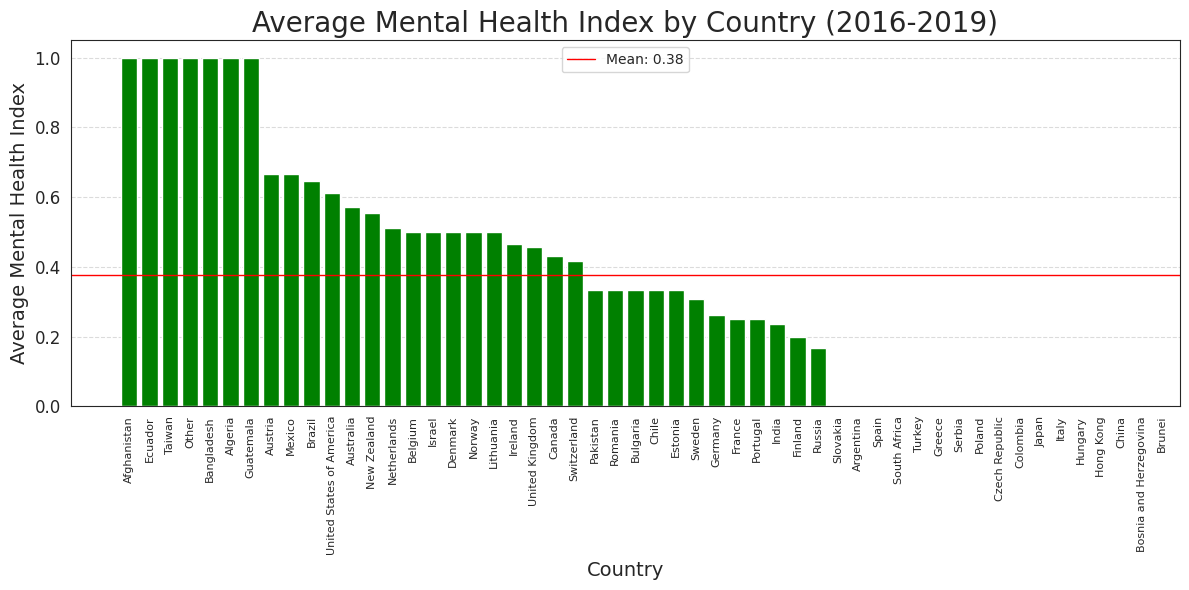

In [69]:
# Mental health by country

import pandas as pd
import matplotlib.pyplot as plt

dataframes = []
for file_path in ["data.csv"]:
    df3 = pd.read_csv(file_path)
    dataframes.append(df3)
df3 = pd.concat(dataframes, ignore_index=True)

if "What country do you live in?" not in df3.columns:
    print("Error: 'What country do you live in?' column not found in your data.")
    exit()

mapping = {"yes": 1, "no": 0, "not sure": pd.NA}
df3["Do you currently have a mental health disorder?"] = df3["Do you currently have a mental health disorder?"].map(mapping)

agg_data = df3.groupby('What country do you live in?')['Do you currently have a mental health disorder?'].mean().reset_index()
agg_data = agg_data.sort_values(by='Do you currently have a mental health disorder?', ascending=False)

# bar chart
plt.figure(figsize=(12, 6))
plt.bar(agg_data['What country do you live in?'], agg_data['Do you currently have a mental health disorder?'], color='green')

# gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# mean value
mean_value = agg_data['Do you currently have a mental health disorder?'].mean()
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=1, label=f'Mean: {mean_value:.2f}')

plt.title('Average Mental Health Index by Country (2016-2019)', fontsize=20)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Mental Health Index', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=12)

plt.legend()

plt.tight_layout()
plt.show()


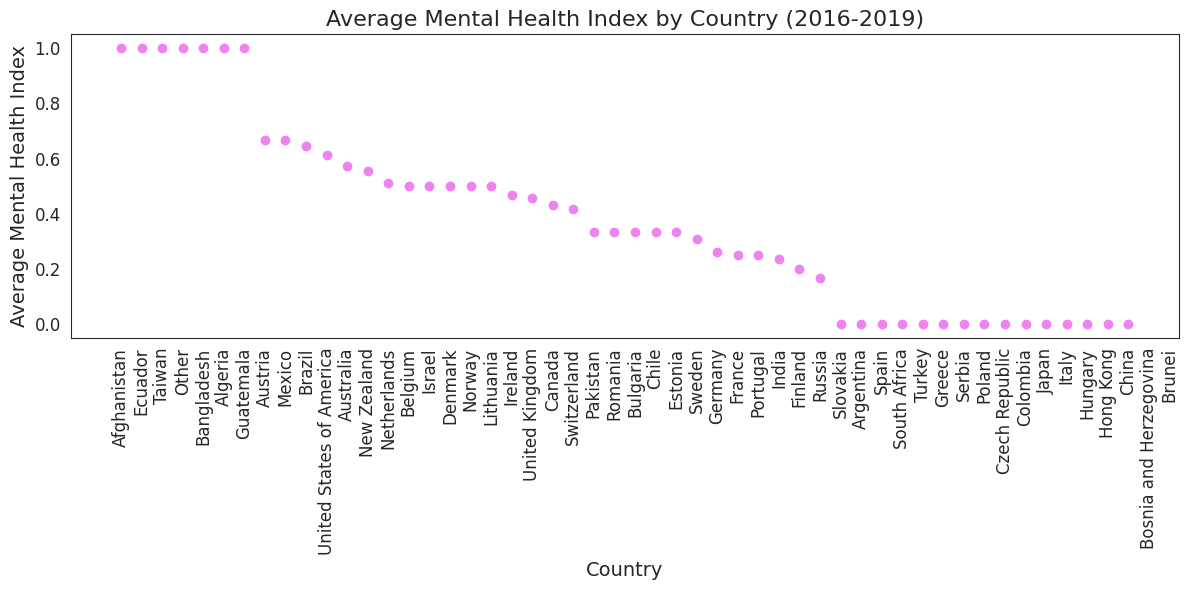

In [70]:
# Mental healty by country 2

import pandas as pd
import matplotlib.pyplot as plt

dataframes = []
for file_path in ["data.csv"]:
    df3 = pd.read_csv(file_path)
    dataframes.append(df3)
df3 = pd.concat(dataframes, ignore_index=True)

if "What country do you live in?" not in df3.columns:
    print("Error: 'What country do you live in?' column not found in your data.")
    exit()

mapping = {"yes": 1, "no": 0, "not sure": pd.NA}
df3["Do you currently have a mental health disorder?"] = df3["Do you currently have a mental health disorder?"].map(mapping)

# Group by country and calculate the mean of mental health index
agg_data = df3.groupby('What country do you live in?')['Do you currently have a mental health disorder?'].mean().reset_index()
agg_data = agg_data.sort_values(by='Do you currently have a mental health disorder?', ascending=False)

# Plot the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(agg_data['What country do you live in?'], agg_data['Do you currently have a mental health disorder?'], color='violet')

# Title and labels
plt.title('Average Mental Health Index by Country (2016-2019)', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Mental Health Index', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


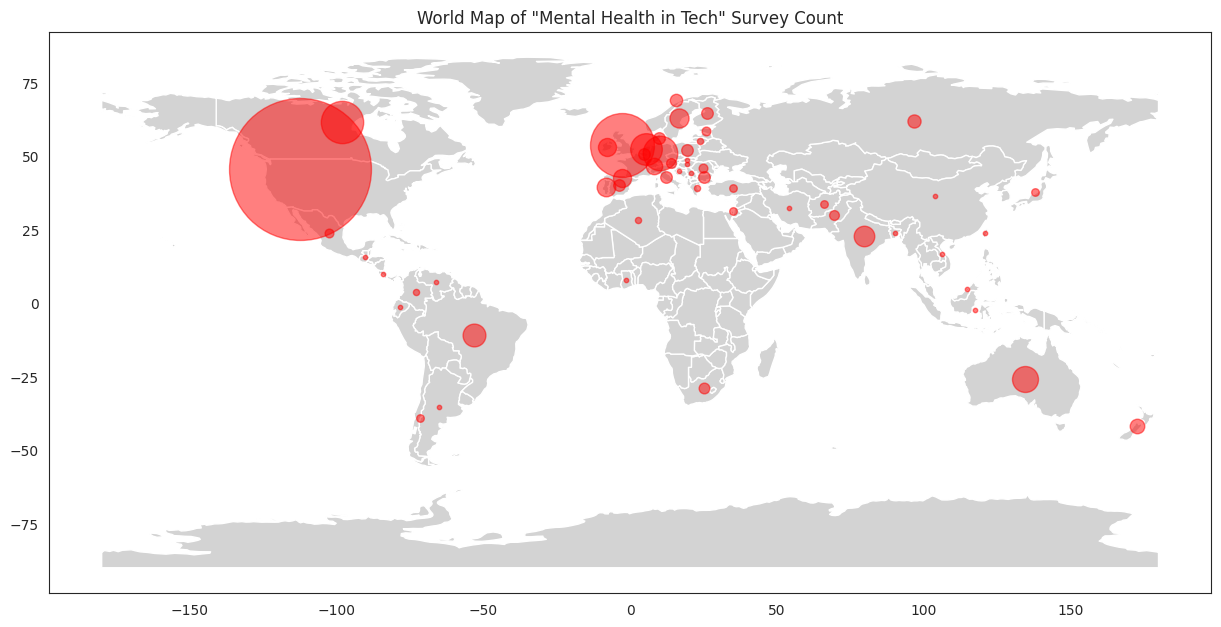

In [85]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

merged_df = pd.read_csv("data.csv")
country_column_name = "What country do you live in?"
survey_count = merged_df[country_column_name].value_counts().reset_index()
survey_count.columns = [country_column_name, "Survey_Count"]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['name_lower'] = world['name'].str.lower()
survey_count[country_column_name] = survey_count[country_column_name].str.lower()
world = world.merge(survey_count, how='left', left_on='name_lower', right_on=country_column_name)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
world.dropna().apply(lambda x: ax.scatter(x.geometry.centroid.x, x.geometry.centroid.y, s=x['Survey_Count']*10, color='red', alpha=0.5), axis=1)
plt.title('World Map of "Mental Health in Tech" Survey Count')
plt.show()

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# Read data from CSV
df = pd.read_csv("data.csv")

# Create dropdown widgets
dropdowns = {}
options = {}

for column in df.columns[:-1]:  # Exclude the 'Year' column
    options[column] = ['All'] + list(df[column].dropna().unique())
    dropdowns[column] = Dropdown(options=options[column], description=f'{column}:')

# Function to update the plot
def update_plot(*args):
    filtered_df = df.copy()
    for column in dropdowns.keys():
        value = dropdowns[column].value
        if value != 'All':
            filtered_df = filtered_df[filtered_df[column] == value]

    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df['What is your age?'], bins=20, color='green')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Age Distribution')
    plt.grid(True)
    plt.show()

# Interact function to update the plot
interact(update_plot, **dropdowns);


interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [74]:
df['Do you currently have a mental health disorder?'].value_counts()

Do you currently have a mental health disorder?
yes         1237
no           969
not sure     752
Name: count, dtype: int64

In [75]:
labels = ['<20', '20s', '30s','40s','50s','>=60']
bins = [0, 20, 30, 40, 50, 60, 150]
df['Age Group'] = pd.cut(df['What is your age?'], bins, labels=labels)
df["Mental Flag"]= df['Do you currently have a mental health disorder?'].apply(lambda x: 1 if x == 'yes' else 0)
df

,Unnamed: 0,How many employees does your company or organization have?,What is your age?,What is your gender?,Do you currently have a mental health disorder?,What country do you live in?,Year,Age Group,Mental Flag
0,0,26-100,39.0,male,no,United Kingdom,2016,30s,0
1,1,6-25,29.0,male,yes,United States of America,2016,20s,1
2,2,6-25,38.0,male,no,United Kingdom,2016,30s,0
3,3,NaN,43.0,male,yes,United Kingdom,2016,40s,1
4,4,6-25,43.0,female,yes,United States of America,2016,40s,1
...,...,...,...,...,...,...,...,...,...
2953,2953,More than 1000,27.0,male,not sure,India,2019,20s,0
2954,2954,NaN,48.0,male,no,United States of America,2019,40s,0
2955,2955,NaN,50.0,male,no,India,2019,40s,0
2956,2956,More than 1000,30.0,female,not sure,India,2019,20s,0


In [76]:
from mmap import MADV_SEQUENTIAL
df_bar = df.groupby("Age Group")["Mental Flag"].sum()/df.groupby("Age Group")["Mental Flag"].count()
df_bar

Age Group
<20     0.259259
20s     0.438716
30s     0.417187
40s     0.383333
50s     0.385965
>=60    0.600000
Name: Mental Flag, dtype: float64

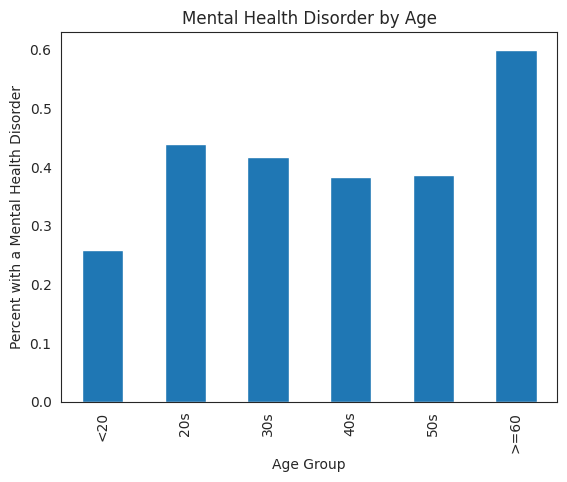

In [78]:
df_bar.plot(kind="bar")
plt.xlabel("Age Group")
plt.ylabel("Percent with a Mental Health Disorder")
plt.title("Mental Health Disorder by Age")
plt.show()

In [79]:
from mmap import MADV_SEQUENTIAL
df_bar = df.groupby(["Age Group", "What is your gender?"])["Mental Flag"].sum()/df.groupby(["Age Group", "What is your gender?"])["Mental Flag"].count()
df_bar

Age Group  What is your gender?
<20        female                  0.444444
           male                    0.176471
           other                   0.000000
20s        female                  0.572347
           male                    0.364179
           other                   0.617021
30s        female                  0.553333
           male                    0.365282
           other                   0.609756
40s        female                  0.529412
           male                    0.337176
           other                   0.285714
50s        female                  0.476190
           male                    0.333333
           other                   0.333333
>=60       female                  0.500000
           male                    0.642857
           other                   1.000000
Name: Mental Flag, dtype: float64

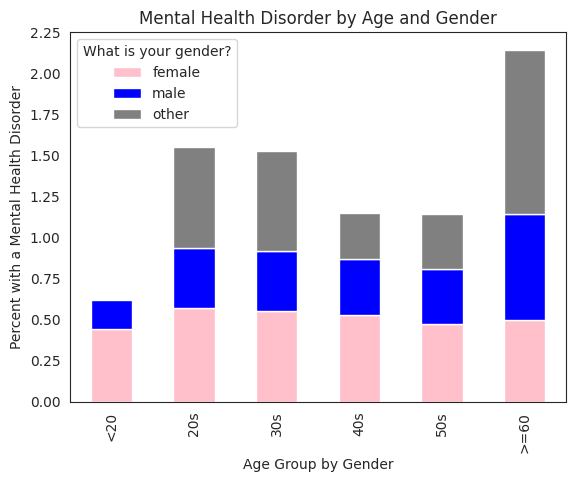

In [80]:
from itertools import cycle, islice
import matplotlib.pyplot as plt
color_palette = {'male': 'blue', 'female': 'pink', 'other': 'grey'}
df_bar = df.groupby(["Age Group", "What is your gender?"])["Mental Flag"].sum() / df.groupby(["Age Group", "What is your gender?"])["Mental Flag"].count()
colors = [color_palette[g] for g in df_bar.index.get_level_values(1)]
df_bar.unstack().plot(kind="bar", stacked=True, color=colors)
plt.xlabel("Age Group by Gender")
plt.ylabel("Percent with a Mental Health Disorder")
plt.title("Mental Health Disorder by Age and Gender")
plt.show()

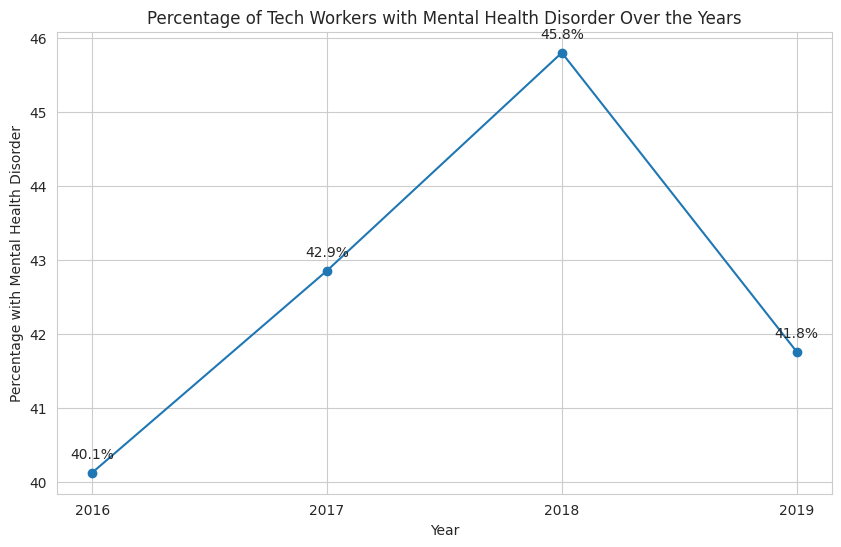

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
years = sorted(df["Year"].unique())
percentages = []
filepath = os.path.join(os.getcwd(), "OSMI Mental Health in Tech Survey 2017.csv")
merged_df = pd.read_csv(filepath)
for year in years:
    year_data = df[df["Year"] == year]
    total_count = len(year_data)
    disorder_count = len(year_data[year_data["Do you currently have a mental health disorder?"] == "yes"])
    percentage = (disorder_count / total_count) * 100
    percentages.append(percentage)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(years, percentages, marker="o")
plt.xlabel("Year")
plt.xticks(years)
plt.ylabel("Percentage with Mental Health Disorder")
plt.title("Percentage of Tech Workers with Mental Health Disorder Over the Years")
# Add data labels
for x, y in zip(years, percentages):
    label = f"{y:.1f}%"  # Format the label with 1 decimal place
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
plt.show()